### What this notebook covers
- Data Contract (schema + constraints)
- QA/QC checks (nulls, duplicates, types, categorical rules)
- Geometry validation & repairs
- CRS/units checks (WGS84 vs projected)
- Spatial sanity checks (bbox containment, unrealistic coordinates)
- Outlier detection (distance-based, density-based)
- Reporting (QA dashboard tables + flags)
- Export GIS-ready artifacts (GeoPackage/GeoJSON/Parquet)

In [1]:
import os
import json
import time
import math
import warnings
from dataclasses import dataclass
from typing import Dict, Any, Optional, List, Tuple

import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point
from shapely.validation import make_valid

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 80)

def log(msg: str):
    print(f"[{time.strftime('%H:%M:%S')}] {msg}")

In [6]:
@dataclass
class QAConfig:
    # Inputs
    in_clean_path: str = "data/01_clean/osm_amenities_clean.parquet"

    # Outputs
    out_dir: str = "data/02_qaqc"
    out_validated_parquet: str = "osm_amenities_validated.parquet"
    out_flags_parquet: str = "osm_amenities_qaqc_flags.parquet"
    out_report_json: str = "qaqc_report.json"
    out_report_csv: str = "qaqc_summary.csv"
    out_geopackage: str = "osm_amenities_validated.gpkg"
    out_geojson: str = "osm_amenities_validated.geojson"

    # Rules / thresholds
    allowed_amenities: Tuple[str, ...] = ("hospital", "school", "fuel", "pharmacy", "police", "fire_station")
    max_reasonable_nn_dist_m_p99: float = 20_000  # sanity (20km) for city-scale bbox
    duplicate_radius_m: float = 15.0  # "near-duplicate" if within 15m and same amenity & name-ish
    suspicious_name_length: int = 120

    # CRS
    crs_wgs84: str = "EPSG:4326"
    crs_projected: str = "EPSG:3857"

cfg = QAConfig()
os.makedirs(cfg.out_dir, exist_ok=True)
cfg


QAConfig(in_clean_path='data/01_clean/osm_amenities_clean.parquet', out_dir='data/02_qaqc', out_validated_parquet='osm_amenities_validated.parquet', out_flags_parquet='osm_amenities_qaqc_flags.parquet', out_report_json='qaqc_report.json', out_report_csv='qaqc_summary.csv', out_geopackage='osm_amenities_validated.gpkg', out_geojson='osm_amenities_validated.geojson', allowed_amenities=('hospital', 'school', 'fuel', 'pharmacy', 'police', 'fire_station'), max_reasonable_nn_dist_m_p99=20000, duplicate_radius_m=15.0, suspicious_name_length=120, crs_wgs84='EPSG:4326', crs_projected='EPSG:3857')

In [7]:
log(f"Loading: {cfg.in_clean_path}")
gdf = gpd.read_parquet(cfg.in_clean_path)

log(f"Loaded shape: {gdf.shape}")
log(f"CRS: {gdf.crs}")
gdf.head()

[12:34:04] Loading: data/01_clean/osm_amenities_clean.parquet
[12:34:04] Loaded shape: (1797, 18)
[12:34:04] CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "WGS 84 / Pseudo-Mercator", "base_crs": {"name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "L

,osm_type,osm_id,amenity,name,operator,brand,addr_city,addr_street,addr_housenumber,addr_postcode,full_address,website,phone,lat,lon,nn_dist_m,raw_tags,geometry
0,node,256556221,pharmacy,None,None,None,None,Йорданська вулиця,17-А,04211,"Йорданська вулиця, 17-А, 04211",www.falbi.ua,None,50.499627,30.503510,160.376924,"{""addr:housenumber"": ""17-А"", ""addr:postcode"": ...",POINT (3395635.201 6533256.325)
1,node,256669242,fuel,БРСМ,БРСМ-Нафта,БРСМ-Нафта,None,проспект Європейського Союзу,39-А,None,"проспект Європейського Союзу, 39-А",None,None,50.504039,30.424838,192.799021,"{""addr:housenumber"": ""39-А"", ""addr:street"": ""п...",POINT (3386877.507 6534028.425)
2,node,266715615,pharmacy,None,None,None,None,None,None,None,None,None,None,50.493282,30.510831,262.456815,"{""amenity"": ""pharmacy"", ""healthcare"": ""pharmacy""}",POINT (3396450.137 6532145.958)
3,node,266893320,fuel,AMIC Energy,None,Amic,None,None,None,None,None,None,None,50.488297,30.503756,201.119147,"{""amenity"": ""fuel"", ""brand"": ""Amic"", ""brand:wi...",POINT (3395662.541 6531273.69)
4,node,266893321,fuel,Grand Petrol,УкрАВТО,None,None,None,None,None,None,None,None,50.487770,30.509108,442.075709,"{""amenity"": ""fuel"", ""name"": ""Grand Petrol"", ""n...",POINT (3396258.345 6531181.536)


In [8]:
assert gdf.crs is not None, "CRS missing. Ensure GeoDataFrame has CRS."
geom_types = gdf.geometry.geom_type.value_counts()
geom_types

,count
Point,1797


In [9]:
if not (geom_types.index == "Point").all():
    log("Non-Point geometries found. Attempting to convert to points via centroid (not ideal for production).")
    gdf["geometry"] = gdf.geometry.centroid

log("Geometry types OK.")

[12:34:28] Geometry types OK.


In [10]:
DATA_CONTRACT = {
    "required_columns": {
        "osm_type": "string",
        "osm_id": "int",
        "amenity": "string",
        "geometry": "geometry",
    },
    "optional_columns": {
        "name": "string",
        "operator": "string",
        "brand": "string",
        "full_address": "string",
        "lat": "float",
        "lon": "float",
        "nn_dist_m": "float",
        "raw_tags": "string",
    },
    "constraints": {
        "amenity_allowed_values": list(cfg.allowed_amenities),
        "osm_type_allowed_values": ["node", "way", "relation"],
        "no_null_geometry": True,
        "unique_key": ["osm_type", "osm_id"],
    }
}

DATA_CONTRACT

{'required_columns': {'osm_type': 'string',
  'osm_id': 'int',
  'amenity': 'string',
  'geometry': 'geometry'},
 'optional_columns': {'name': 'string',
  'operator': 'string',
  'brand': 'string',
  'full_address': 'string',
  'lat': 'float',
  'lon': 'float',
  'nn_dist_m': 'float',
  'raw_tags': 'string'},
 'constraints': {'amenity_allowed_values': ['hospital',
   'school',
   'fuel',
   'pharmacy',
   'police',
   'fire_station'],
  'osm_type_allowed_values': ['node', 'way', 'relation'],
  'no_null_geometry': True,
  'unique_key': ['osm_type', 'osm_id']}}

In [11]:
def validate_contract(gdf: gpd.GeoDataFrame, contract: Dict[str, Any]) -> Dict[str, Any]:
    results = {
        "missing_required_columns": [],
        "type_mismatches": [],
        "violations": [],
        "passed": True
    }

    # required cols
    for col in contract["required_columns"]:
        if col not in gdf.columns:
            results["missing_required_columns"].append(col)

    if results["missing_required_columns"]:
        results["passed"] = False
        return results

    # categorical constraints
    c = contract["constraints"]

    if "amenity_allowed_values" in c:
        bad = gdf.loc[~gdf["amenity"].isin(c["amenity_allowed_values"]), "amenity"].unique().tolist()
        if bad:
            results["violations"].append({"amenity_allowed_values": bad})

    if "osm_type_allowed_values" in c:
        bad = gdf.loc[~gdf["osm_type"].isin(c["osm_type_allowed_values"]), "osm_type"].unique().tolist()
        if bad:
            results["violations"].append({"osm_type_allowed_values": bad})

    # unique key
    key = c.get("unique_key")
    if key:
        dup = gdf.duplicated(subset=key, keep=False).sum()
        if dup > 0:
            results["violations"].append({"duplicate_primary_key_rows": int(dup)})

    # geometry non-null
    if c.get("no_null_geometry", False):
        null_geom = gdf.geometry.isna().sum()
        if null_geom > 0:
            results["violations"].append({"null_geometry_rows": int(null_geom)})

    if results["missing_required_columns"] or results["type_mismatches"] or results["violations"]:
        results["passed"] = False

    return results

contract_result = validate_contract(gdf, DATA_CONTRACT)
contract_result

{'missing_required_columns': [],
 'type_mismatches': [],
 'violations': [],
 'passed': True}

In [12]:
def init_flags(gdf: gpd.GeoDataFrame) -> pd.DataFrame:
    flags = pd.DataFrame(index=gdf.index)
    flags["flag_any"] = False
    return flags

flags = init_flags(gdf)

In [13]:
def flag_nulls(flags: pd.DataFrame, gdf: gpd.GeoDataFrame) -> pd.DataFrame:
    flags["flag_null_geometry"] = gdf.geometry.isna()
    flags["flag_null_amenity"] = gdf["amenity"].isna()
    flags["flag_null_osm_id"] = gdf["osm_id"].isna()
    return flags

flags = flag_nulls(flags, gdf)
flags[["flag_null_geometry","flag_null_amenity","flag_null_osm_id"]].sum()

,0
flag_null_geometry,0
flag_null_amenity,0
flag_null_osm_id,0


In [14]:
pk = DATA_CONTRACT["constraints"]["unique_key"]
flags["flag_duplicate_pk"] = gdf.duplicated(subset=pk, keep=False)
int(flags["flag_duplicate_pk"].sum())

0

In [15]:
allowed = set(cfg.allowed_amenities)
flags["flag_bad_amenity"] = ~gdf["amenity"].isin(allowed)
int(flags["flag_bad_amenity"].sum()), gdf.loc[flags["flag_bad_amenity"], "amenity"].unique()[:10]

(0, array([], dtype=object))

In [16]:
def is_suspicious_name(x: Optional[str], max_len: int) -> bool:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return False
    x = str(x)
    if len(x) > max_len:
        return True
    # too many symbols
    non_alnum = sum([1 for ch in x if not ch.isalnum() and ch not in " -.,'()&/"])
    if len(x) > 0 and (non_alnum / len(x)) > 0.25:
        return True
    return False

flags["flag_suspicious_name"] = gdf["name"].apply(lambda v: is_suspicious_name(v, cfg.suspicious_name_length))
int(flags["flag_suspicious_name"].sum())

2

In [17]:
flags["flag_invalid_geom"] = ~gdf.geometry.is_valid
flags["flag_empty_geom"] = gdf.geometry.is_empty
int(flags["flag_invalid_geom"].sum()), int(flags["flag_empty_geom"].sum())

(0, 0)

In [18]:
gdf_fixed = gdf.copy()

if flags["flag_invalid_geom"].any():
    log("Fixing invalid geometries with make_valid() ...")
    gdf_fixed.loc[flags["flag_invalid_geom"], "geometry"] = (
        gdf_fixed.loc[flags["flag_invalid_geom"], "geometry"].apply(make_valid)
    )

# Recompute validity
flags["flag_invalid_geom_after_fix"] = ~gdf_fixed.geometry.is_valid
int(flags["flag_invalid_geom_after_fix"].sum())

0

In [19]:
if "lat" in gdf_fixed.columns and "lon" in gdf_fixed.columns:
    flags["flag_bad_lat"] = ~gdf_fixed["lat"].between(-90, 90, inclusive="both")
    flags["flag_bad_lon"] = ~gdf_fixed["lon"].between(-180, 180, inclusive="both")
    log(f"Bad lat: {int(flags['flag_bad_lat'].sum())}, bad lon: {int(flags['flag_bad_lon'].sum())}")
else:
    log("lat/lon columns not found, skipping lat/lon plausibility checks.")

[12:36:29] Bad lat: 0, bad lon: 0


In [20]:
min_lon, min_lat, max_lon, max_lat = (30.38, 50.40, 30.62, 50.52)  # keep consistent with notebook01 if needed

gdf_wgs = gdf_fixed.to_crs(cfg.crs_wgs84)
flags["flag_outside_bbox"] = (
    (gdf_wgs.geometry.x < min_lon) | (gdf_wgs.geometry.x > max_lon) |
    (gdf_wgs.geometry.y < min_lat) | (gdf_wgs.geometry.y > max_lat)
)
int(flags["flag_outside_bbox"].sum())

11

In [21]:
gdf_proj = gdf_fixed.to_crs(cfg.crs_projected).copy()
coords = np.vstack([gdf_proj.geometry.x.values, gdf_proj.geometry.y.values]).T

In [22]:
from sklearn.neighbors import BallTree

# BallTree expects radians for haversine, but we are in meters (EPSG:3857).
# We'll use euclidean BallTree over projected
tree = BallTree(coords, metric="euclidean")

radius = cfg.duplicate_radius_m
ind = tree.query_radius(coords, r=radius)

# Mark rows that have neighbors other than self
near_dup = np.array([len(i) > 1 for i in ind])
flags["flag_near_duplicate_spatial"] = near_dup

int(flags["flag_near_duplicate_spatial"].sum())

78

In [23]:
def normalize_name(x: Optional[str]) -> str:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return ""
    x = str(x).lower().strip()
    x = "".join(ch for ch in x if ch.isalnum() or ch.isspace())
    x = " ".join(x.split())
    return x

name_norm = gdf_fixed["name"].apply(normalize_name).values
amenity = gdf_fixed["amenity"].fillna("").values

near_dup_refined = np.zeros(len(gdf_fixed), dtype=bool)

for i, neigh in enumerate(ind):
    if len(neigh) <= 1:
        continue
    # Compare only same amenity; name optional
    for j in neigh:
        if i == j:
            continue
        if amenity[i] and amenity[i] == amenity[j]:
            # if both names exist, compare normalized; else allow match
            if (name_norm[i] and name_norm[j] and name_norm[i] == name_norm[j]) or (not name_norm[i] or not name_norm[j]):
                near_dup_refined[i] = True
                break

flags["flag_near_duplicate_refined"] = near_dup_refined
int(flags["flag_near_duplicate_refined"].sum())

28

In [24]:
if "nn_dist_m" in gdf_fixed.columns:
    # Use percentiles to detect extreme spatial isolation
    p99 = np.nanpercentile(gdf_fixed["nn_dist_m"].values, 99)
    flags["flag_nn_outlier_p99"] = gdf_fixed["nn_dist_m"] > min(p99, cfg.max_reasonable_nn_dist_m_p99)
    log(f"p99 nn_dist_m: {p99:.1f}")
    int(flags["flag_nn_outlier_p99"].sum())
else:
    log("nn_dist_m column not present. Skipping nn-based outliers.")

[12:37:36] p99 nn_dist_m: 789.9


In [25]:
flag_cols = [c for c in flags.columns if c.startswith("flag_") and c != "flag_any"]
flags["flag_any"] = flags[flag_cols].any(axis=1)

log(f"Rows with ANY issue: {int(flags['flag_any'].sum())} / {len(flags)}")

[12:37:46] Rows with ANY issue: 108 / 1797


In [26]:
WEIGHTS = {
    "flag_null_geometry": 10,
    "flag_null_amenity": 10,
    "flag_null_osm_id": 10,
    "flag_duplicate_pk": 8,
    "flag_bad_amenity": 6,
    "flag_invalid_geom": 8,
    "flag_invalid_geom_after_fix": 10,
    "flag_outside_bbox": 6,
    "flag_near_duplicate_refined": 4,
    "flag_near_duplicate_spatial": 2,
    "flag_suspicious_name": 2,
    "flag_nn_outlier_p99": 2,
}

def compute_score(flags: pd.DataFrame, weights: Dict[str, int]) -> pd.Series:
    score = pd.Series(0, index=flags.index, dtype=int)
    for k, w in weights.items():
        if k in flags.columns:
            score += flags[k].astype(int) * int(w)
    return score

flags["qaqc_score"] = compute_score(flags, WEIGHTS)

flags["qaqc_bucket"] = pd.cut(
    flags["qaqc_score"],
    bins=[-1, 0, 3, 7, 15, 10_000],
    labels=["PASS", "LOW", "MED", "HIGH", "CRITICAL"]
)

flags["qaqc_bucket"].value_counts()

,count
qaqc_bucket,
PASS,1689
LOW,69
MED,38
HIGH,1
CRITICAL,0


In [27]:
summary_rows = []
for col in flag_cols:
    summary_rows.append({
        "check": col,
        "failed_rows": int(flags[col].sum()),
        "failed_pct": float(flags[col].mean() * 100)
    })

summary_df = pd.DataFrame(summary_rows).sort_values("failed_rows", ascending=False)
summary_df.head(20)

,check,failed_rows,failed_pct
12,flag_near_duplicate_spatial,78,4.340568
13,flag_near_duplicate_refined,28,1.558152
14,flag_nn_outlier_p99,18,1.001669
11,flag_outside_bbox,11,0.612131
5,flag_suspicious_name,2,0.111297
1,flag_null_amenity,0,0.000000
0,flag_null_geometry,0,0.000000
6,flag_invalid_geom,0,0.000000
4,flag_bad_amenity,0,0.000000
3,flag_duplicate_pk,0,0.000000


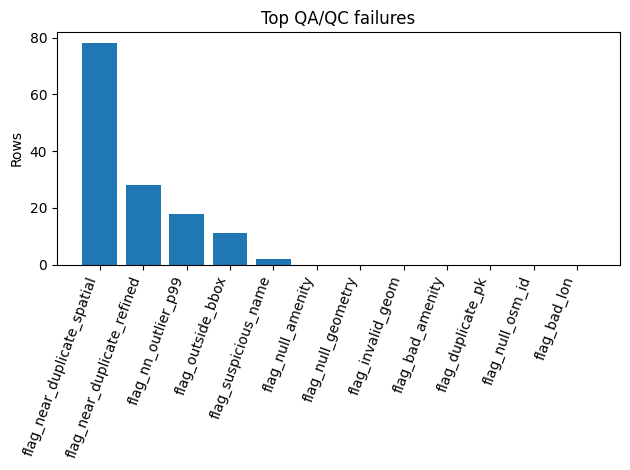

In [28]:
plt.figure()
plt.bar(summary_df["check"].head(12), summary_df["failed_rows"].head(12))
plt.xticks(rotation=70, ha="right")
plt.title("Top QA/QC failures")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

In [29]:
audit_cols = ["osm_type", "osm_id", "amenity", "name"]
audit = gdf_fixed[audit_cols].copy()

for c in flag_cols + ["qaqc_score", "qaqc_bucket"]:
    audit[c] = flags[c]

audit.sort_values(["qaqc_score"], ascending=False).head(30)

,osm_type,osm_id,amenity,name,flag_null_geometry,flag_null_amenity,flag_null_osm_id,flag_duplicate_pk,flag_bad_amenity,flag_suspicious_name,flag_invalid_geom,flag_empty_geom,flag_invalid_geom_after_fix,flag_bad_lat,flag_bad_lon,flag_outside_bbox,flag_near_duplicate_spatial,flag_near_duplicate_refined,flag_nn_outlier_p99,qaqc_score,qaqc_bucket
1765,relation,7073084,school,Військовий ліцей імені Івана Богуна,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,8,HIGH
1690,way,1414329354,fire_station,None,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,6,MED
1713,way,1433437764,police,None,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,6,MED
1708,way,1429210809,police,None,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,6,MED
1675,way,1358991953,school,Ліцей №8,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,6,MED
1634,way,986023623,school,Школа №308,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,6,MED
1614,way,940384633,fuel,None,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,6,MED
1669,way,1339469234,school,Школа №5,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,6,MED
1565,way,764576742,school,Ліцей №196,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,6,MED
1557,way,741868666,hospital,Інститут ендокринології та обміну речовин ім. ...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,6,MED


In [30]:
validated_mask = flags["qaqc_bucket"].isin(["PASS", "LOW", "MED"])
quarantine_mask = flags["qaqc_bucket"].isin(["HIGH", "CRITICAL"])

gdf_validated = gdf_fixed.loc[validated_mask].copy()
gdf_quarantine = gdf_fixed.loc[quarantine_mask].copy()

log(f"Validated: {len(gdf_validated)} | Quarantine: {len(gdf_quarantine)}")

[12:38:47] Validated: 1796 | Quarantine: 1


In [31]:
# Example rule: if exact duplicate pk exists, keep first
gdf_validated = gdf_validated.drop_duplicates(subset=pk, keep="first")

# Example rule: if near-duplicate refined, keep the one with more metadata filled
if "flag_near_duplicate_refined" in flags.columns:
    # Compute "completeness"
    meta_cols = ["name", "full_address", "operator", "brand", "website", "phone"]
    for c in meta_cols:
        if c not in gdf_validated.columns:
            gdf_validated[c] = None

    completeness = gdf_validated[meta_cols].notna().sum(axis=1)
    gdf_validated["_completeness"] = completeness

    # Keep best record per
    gdf_proj_tmp = gdf_validated.to_crs(cfg.crs_projected)
    gdf_validated["_x_round"] = (gdf_proj_tmp.geometry.x / 5).round().astype(int)  # 5m grid
    gdf_validated["_y_round"] = (gdf_proj_tmp.geometry.y / 5).round().astype(int)

    gdf_validated = (
        gdf_validated
        .sort_values("_completeness", ascending=False)
        .drop_duplicates(subset=["amenity", "_x_round", "_y_round"], keep="first")
        .drop(columns=["_completeness", "_x_round", "_y_round"])
    )

log(f"Post-fix validated count: {len(gdf_validated)}")

[12:39:02] Post-fix validated count: 1793


In [32]:
flags_path = os.path.join(cfg.out_dir, cfg.out_flags_parquet)
flags.to_parquet(flags_path, index=False)
log(f"Saved flags: {flags_path}")

summary_path = os.path.join(cfg.out_dir, cfg.out_report_csv)
summary_df.to_csv(summary_path, index=False)
log(f"Saved summary CSV: {summary_path}")

[12:39:14] Saved flags: data/02_qaqc/osm_amenities_qaqc_flags.parquet
[12:39:14] Saved summary CSV: data/02_qaqc/qaqc_summary.csv


In [33]:
report = {
    "input_path": cfg.in_clean_path,
    "n_input": int(len(gdf)),
    "n_validated": int(len(gdf_validated)),
    "n_quarantine": int(len(gdf_quarantine)),
    "bucket_counts": flags["qaqc_bucket"].value_counts().to_dict(),
    "top_failures": summary_df.head(10).to_dict(orient="records"),
    "contract_passed": bool(contract_result.get("passed", False)),
    "contract_details": contract_result,
}

report_path = os.path.join(cfg.out_dir, cfg.out_report_json)
with open(report_path, "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

log(f"Saved QA report JSON: {report_path}")
report

[12:39:25] Saved QA report JSON: data/02_qaqc/qaqc_report.json


{'input_path': 'data/01_clean/osm_amenities_clean.parquet',
 'n_input': 1797,
 'n_validated': 1793,
 'n_quarantine': 1,
 'bucket_counts': {'PASS': 1689,
  'LOW': 69,
  'MED': 38,
  'HIGH': 1,
  'CRITICAL': 0},
 'top_failures': [{'check': 'flag_near_duplicate_spatial',
   'failed_rows': 78,
   'failed_pct': 4.340567612687813},
  {'check': 'flag_near_duplicate_refined',
   'failed_rows': 28,
   'failed_pct': 1.5581524763494714},
  {'check': 'flag_nn_outlier_p99',
   'failed_rows': 18,
   'failed_pct': 1.001669449081803},
  {'check': 'flag_outside_bbox',
   'failed_rows': 11,
   'failed_pct': 0.6121313299944352},
  {'check': 'flag_suspicious_name',
   'failed_rows': 2,
   'failed_pct': 0.11129660545353368},
  {'check': 'flag_null_amenity', 'failed_rows': 0, 'failed_pct': 0.0},
  {'check': 'flag_null_geometry', 'failed_rows': 0, 'failed_pct': 0.0},
  {'check': 'flag_invalid_geom', 'failed_rows': 0, 'failed_pct': 0.0},
  {'check': 'flag_bad_amenity', 'failed_rows': 0, 'failed_pct': 0.0},
  

In [34]:
validated_parquet_path = os.path.join(cfg.out_dir, cfg.out_validated_parquet)
gdf_validated.to_parquet(validated_parquet_path, index=False)
log(f"Saved validated parquet: {validated_parquet_path}")

gpkg_path = os.path.join(cfg.out_dir, cfg.out_geopackage)
gdf_validated.to_file(gpkg_path, layer="amenities_validated", driver="GPKG")
log(f"Saved GeoPackage: {gpkg_path}")

geojson_path = os.path.join(cfg.out_dir, cfg.out_geojson)
gdf_validated.to_crs(cfg.crs_wgs84).to_file(geojson_path, driver="GeoJSON")
log(f"Saved GeoJSON: {geojson_path}")

[12:39:37] Saved validated parquet: data/02_qaqc/osm_amenities_validated.parquet
[12:39:38] Saved GeoPackage: data/02_qaqc/osm_amenities_validated.gpkg
[12:39:39] Saved GeoJSON: data/02_qaqc/osm_amenities_validated.geojson


In [35]:
md = f"""
## QA/QC Result Summary

- **Input rows:** {report['n_input']}
- **Validated rows:** {report['n_validated']}
- **Quarantined rows:** {report['n_quarantine']}
- **Contract passed:** {report['contract_passed']}

### Bucket distribution
{json.dumps(report['bucket_counts'], ensure_ascii=False, indent=2)}

### Top failures
{json.dumps(report['top_failures'], ensure_ascii=False, indent=2)}

**Outputs**
- Validated Parquet: `{validated_parquet_path}`
- QA flags: `{flags_path}`
- QA report: `{report_path}`
- GeoPackage: `{gpkg_path}`
- GeoJSON: `{geojson_path}`
"""
print(md)


## QA/QC Result Summary

- **Input rows:** 1797
- **Validated rows:** 1793
- **Quarantined rows:** 1
- **Contract passed:** True

### Bucket distribution
{
  "PASS": 1689,
  "LOW": 69,
  "MED": 38,
  "HIGH": 1,
  "CRITICAL": 0
}

### Top failures
[
  {
    "check": "flag_near_duplicate_spatial",
    "failed_rows": 78,
    "failed_pct": 4.340567612687813
  },
  {
    "check": "flag_near_duplicate_refined",
    "failed_rows": 28,
    "failed_pct": 1.5581524763494714
  },
  {
    "check": "flag_nn_outlier_p99",
    "failed_rows": 18,
    "failed_pct": 1.001669449081803
  },
  {
    "check": "flag_outside_bbox",
    "failed_rows": 11,
    "failed_pct": 0.6121313299944352
  },
  {
    "check": "flag_suspicious_name",
    "failed_rows": 2,
    "failed_pct": 0.11129660545353368
  },
  {
    "check": "flag_null_amenity",
    "failed_rows": 0,
    "failed_pct": 0.0
  },
  {
    "check": "flag_null_geometry",
    "failed_rows": 0,
    "failed_pct": 0.0
  },
  {
    "check": "flag_invalid_geom",